In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imread
import tensorflow as tf
import tensorflow.contrib.slim as slim
from utils import unpool_with_argmax
%matplotlib inline

In [2]:
train_file = 'CamVid/train.txt'
val_file = 'CamVid/val.txt'
test_file = 'CamVid/test.txt'

In [3]:
IMAGE_HEIGHT = 360
IMAGE_WIDTH = 480
IMAGE_DEPTH = 3
NUM_CLASSES = 12
TRAIN_BATCH_SIZE=8
VAL_BATCH_SIZE=TRAIN_BATCH_SIZE
TEST_BATCH_SIZE = 1
NUM_ITERS = 20000

In [4]:
def get_label_colors():
    Sky = [128,128,128]
    Building = [128,0,0]
    Pole = [192,192,128]
    Road_marking = [255,69,0]
    Road = [128,64,128]
    Pavement = [60,40,222]
    Tree = [128,128,0]
    SignSymbol = [192,128,128]
    Fence = [64,64,128]
    Car = [64,0,128]
    Pedestrian = [64,64,0]
    Bicyclist = [0,128,192]
    Unlabelled = [0,0,0]

    label_colors = np.array([Sky, Building, Pole, Road, Pavement, Tree, SignSymbol, 
                             Fence, Car, Pedestrian, Bicyclist, Unlabelled])
    return label_colors

def img_annot_to_rgb(img_annot):
    r = img_annot.copy()
    g = img_annot.copy()
    b = img_annot.copy()
    label_colors = get_label_colors()
    for i in range(len(label_colors)):
        r[img_annot==i]=label_colors[i,0]
        g[img_annot==i]=label_colors[i,1]
        b[img_annot==i]=label_colors[i,2]
    return np.stack([r,g,b],axis=2)/255.0

def visualize_image_annot(img_data, annot_data, predicted_annot=None):
    if predicted_annot is None:
        fig, ax = plt.subplots(1,2,figsize=(10,12))
        ax[0].imshow(img_data)
        ax[0].set_title('Original Image')
        ax[1].imshow(img_annot_to_rgb(annot_data))
        ax[1].set_title('True Segmentation')
        plt.show()
    else:
        fig, ax = plt.subplots(1,3,figsize=(10,12))
        ax[0].imshow(img_data)
        ax[0].set_title('Original Image')
        ax[1].imshow(img_annot_to_rgb(predicted_annot))
        ax[1].set_title('Predicted Segmentation')
        ax[2].imshow(img_annot_to_rgb(annot_data))
        ax[2].set_title('True Segmentation')
        plt.show()

In [5]:
def load_data(file, train=True, batch_size=10, labels=True):
    def _load_image(filename):
        image_string = tf.read_file(filenames[0])
        image_decoded = tf.image.decode_png(image_string, channels=3)
        image_decoded = tf.image.convert_image_dtype(image_decoded,tf.float32)
        return image_decoded

    def _load_image_with_labels(filenames):
        image_string = tf.read_file(filenames[0])
        image_decoded = tf.image.decode_png(image_string, channels=3)
        image_decoded = tf.image.convert_image_dtype(image_decoded,tf.float32)
        annot_string = tf.read_file(filenames[1])
        annot_decoded = tf.squeeze(tf.image.decode_image(annot_string),axis=2)
        annot_decoded = tf.cast(annot_decoded, tf.int64)
        return image_decoded, annot_decoded

    dataset = tf.contrib.data.Dataset.from_tensor_slices(tf.constant([file]))
    dataset =  dataset.flat_map(lambda filename: tf.contrib.data.TextLineDataset(filename))
    dataset = dataset.map(lambda line: tf.string_split([line], delimiter=' ').values)
    if labels:
        dataset = dataset.map(_load_image_with_labels)
    else:
        dataset = dataset.map(_load_image)
    if train is True:
        dataset = dataset.shuffle(buffer_size=batch_size*3)
    dataset = dataset.batch(batch_size=batch_size)
    iterator = dataset.make_initializable_iterator()
    return iterator

In [6]:
def inference_scope(is_training, batch_norm_decay=0.9):
    with slim.arg_scope([slim.conv2d],
                        activation_fn=tf.nn.relu,
                        weights_initializer=tf.truncated_normal_initializer(stddev=0.01),
                        normalizer_fn=slim.batch_norm,
                        stride=1,
                        padding='SAME'):

        with slim.arg_scope([slim.batch_norm],
                            is_training=is_training,
                            decay=batch_norm_decay) as scope:
            return scope

def inference(images, class_inc_bg = None):

    tf.summary.image('input', images, max_outputs=3)

    with tf.variable_scope('pool1'):
        net = slim.conv2d(images, 64, [3, 3], scope='conv1_1')
        net = slim.conv2d(net, 64, [3, 3], scope='conv1_2')
        net, arg1 = tf.nn.max_pool_with_argmax(net, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='maxpool1')

    with tf.variable_scope('pool2'):
        net = slim.conv2d(net, 128, [3, 3], scope='conv2_1')
        net = slim.conv2d(net, 128, [3, 3], scope='conv2_2')
        net, arg2 = tf.nn.max_pool_with_argmax(net, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='maxpool2')

    with tf.variable_scope('pool3'):
        net = slim.conv2d(net, 256, [3, 3], scope='conv3_1')
        net = slim.conv2d(net, 256, [3, 3], scope='conv3_2')
        net = slim.conv2d(net, 256, [3, 3], scope='conv3_3')
        net, arg3 = tf.nn.max_pool_with_argmax(net, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='maxpool3')

    with tf.variable_scope('unpool3'):
        net = unpool_with_argmax(net, arg3, name='maxunpool3')
        net = slim.conv2d(net, 256, [3, 3], scope='uconv3_3')
        net = slim.conv2d(net, 256, [3, 3], scope='uconv3_2')
        net = slim.conv2d(net, 128, [3, 3], scope='uconv3_1')

    with tf.variable_scope('unpool2'):
        net = unpool_with_argmax(net, arg2, name='maxunpool2')
        net = slim.conv2d(net, 128, [3, 3], scope='uconv2_2')
        net = slim.conv2d(net, 64, [3, 3], scope='uconv2_1')

    with tf.variable_scope('unpool1'):
        net = unpool_with_argmax(net, arg1, name='maxunpool1')
        net = slim.conv2d(net, 64, [3, 3], scope='uconv1_2')
        logits = slim.conv2d(net, class_inc_bg, [3, 3], scope='uconv1_1')
    predicted_annotations = tf.argmax(logits,axis=3)
    return logits, predicted_annotations

In [7]:
tf.reset_default_graph()
train_iterator = load_data(train_file, batch_size=TRAIN_BATCH_SIZE)
val_iterator = load_data(val_file, train=False, batch_size=TRAIN_BATCH_SIZE)
test_iterator = load_data(test_file, train=False)

In [8]:
def get_inputs(batch_size):
    inputs = tf.placeholder(tf.float32, [batch_size, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH ])
    labels = tf.placeholder(tf.int64,[batch_size, IMAGE_HEIGHT, IMAGE_WIDTH])
    is_training = tf.placeholder(tf.bool)
    return inputs, labels, is_training

In [9]:
def compute_loss(logits, labels):
    ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels)
    loss = tf.reduce_mean(ce)
    tf.summary.scalar('loss', loss)
    return loss

def compute_accuracy(logits, labels):
    correct_prediction = tf.equal(tf.argmax(logits, 3), labels)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar('accuracy', accuracy)
    return accuracy

def training_op(loss, learning_rate):
    global_step = tf.Variable(0, name='global_step', trainable=False)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        optimizer = tf.train.AdamOptimizer(learning_rate=0.1).minimize(loss, global_step=global_step)
    return optimizer, global_step

In [10]:
arg_scope = inference_scope(is_training=True, batch_norm_decay=0.95)
inputs, labels, is_training = get_inputs(batch_size=TRAIN_BATCH_SIZE)
with slim.arg_scope(arg_scope):
    logits, predicted_annotations = inference(inputs, class_inc_bg=NUM_CLASSES)

In [11]:
loss = compute_loss(logits, labels)
optimizer, global_step = training_op(loss, 0.0001)
accuracy = compute_accuracy(logits, labels)

In [ ]:
def build_segnet():
    class SegnetModel():
        pass
    segnet_model = SegnetModel()
    
    arg_scope = inference_scope(is_training=True, batch_norm_decay=0.95)
    inputs, labels, is_training = get_inputs(batch_size=TRAIN_BATCH_SIZE)
    with slim.arg_scope(arg_scope):
        logits, predicted_annotations = inference(inputs, class_inc_bg=NUM_CLASSES)
    loss = compute_loss(logits, labels)
    optimizer, global_step = training_op(loss, 0.0001)
    accuracy = compute_accuracy(logits, labels)
    

Iter: 0,Loss: 2.6300435066223145, Acc:0.08825449645519257
Iter: 100,Loss: 1.6466821432113647, Acc:0.46585020422935486
Val Acc:0.38661521673202515


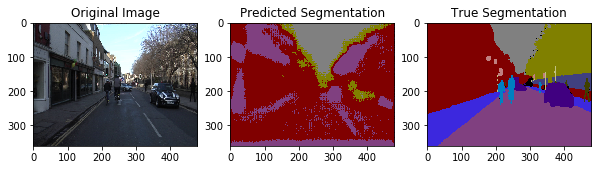

Iter: 200,Loss: 1.2254877090454102, Acc:0.64279705286026
Val Acc:0.45988261699676514


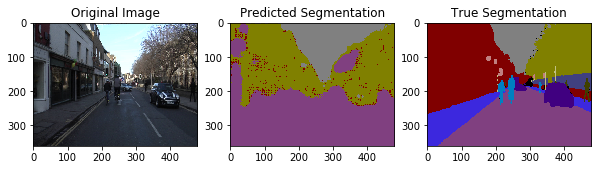

Iter: 300,Loss: 1.0703176259994507, Acc:0.6280517578125
Val Acc:0.518720805644989


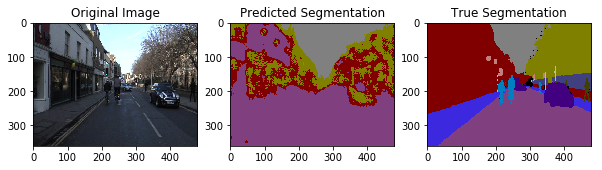

Iter: 400,Loss: 1.1636723279953003, Acc:0.6796701550483704
Val Acc:0.6272770762443542


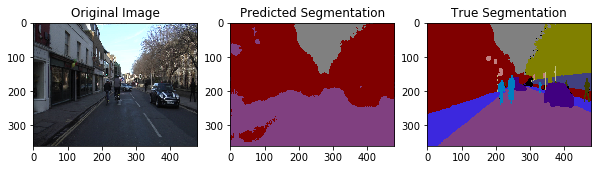

Iter: 500,Loss: 1.4419236183166504, Acc:0.5451157689094543
Val Acc:0.49709853529930115


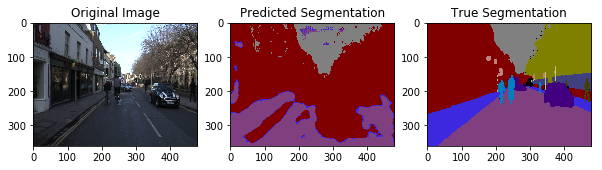

Iter: 600,Loss: 1.050942301750183, Acc:0.6943097114562988
Val Acc:0.5630084276199341


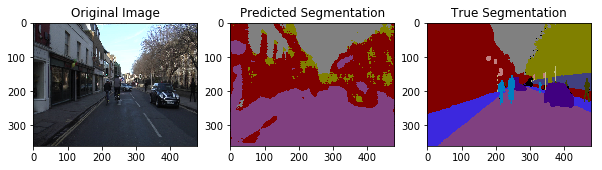

Iter: 700,Loss: 1.2885053157806396, Acc:0.6161437630653381
Val Acc:0.4838908612728119


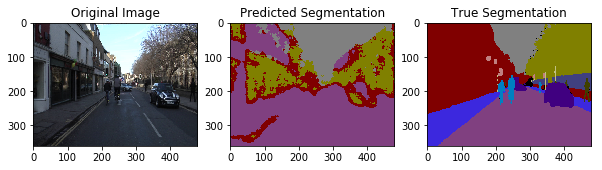

Iter: 800,Loss: 1.025994062423706, Acc:0.7389896512031555
Val Acc:0.5815058350563049


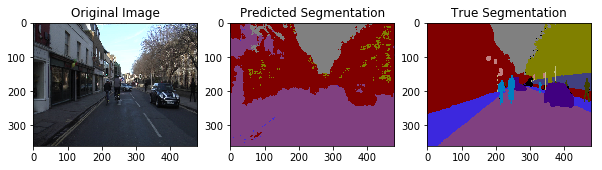

Iter: 900,Loss: 1.729090929031372, Acc:0.443255752325058
Val Acc:0.6396104097366333


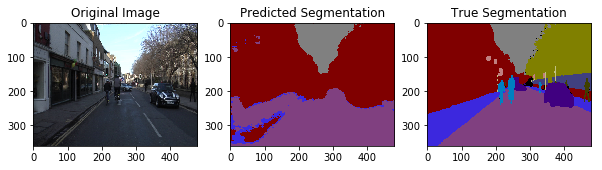

Iter: 1000,Loss: 1.39187753200531, Acc:0.5438817739486694
Val Acc:0.5677234530448914


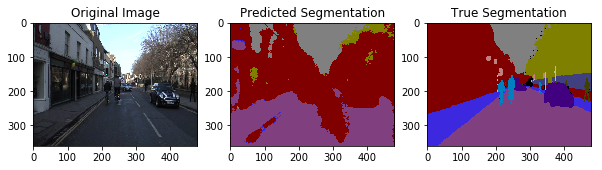

Iter: 1100,Loss: 1.0347942113876343, Acc:0.7468584179878235
Val Acc:0.5816746354103088


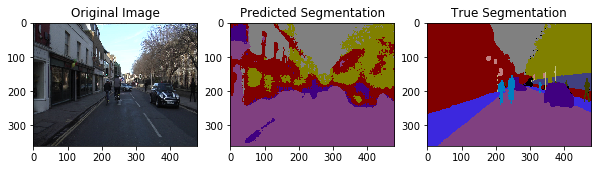

Iter: 1200,Loss: 0.9635260701179504, Acc:0.7280421257019043
Val Acc:0.5557436943054199


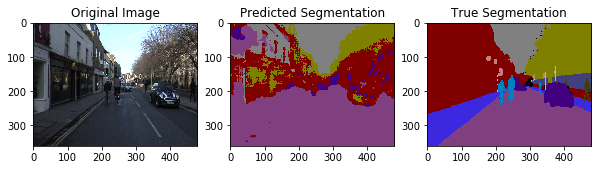

Iter: 1300,Loss: 1.1603621244430542, Acc:0.6596370339393616
Val Acc:0.634774386882782


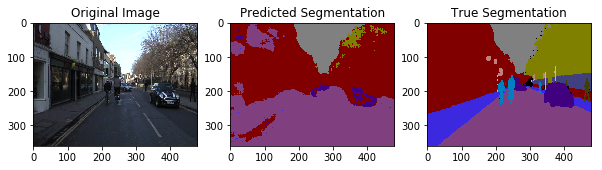

Iter: 1400,Loss: 1.2233983278274536, Acc:0.6228088140487671
Val Acc:0.592724084854126


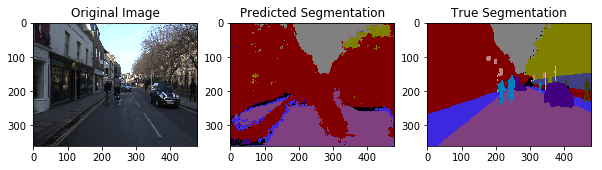

Iter: 1500,Loss: 0.9995085000991821, Acc:0.7361754179000854
Val Acc:0.5842059850692749


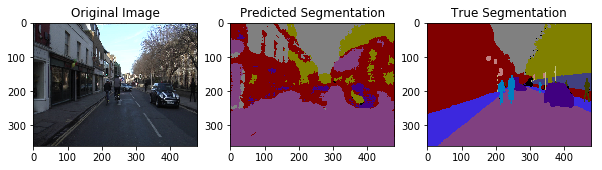

Iter: 1600,Loss: 1.200956106185913, Acc:0.6818633675575256
Val Acc:0.6153719425201416


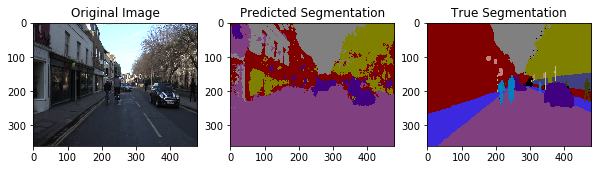

Iter: 1700,Loss: 1.0556344985961914, Acc:0.706960916519165
Val Acc:0.6637901663780212


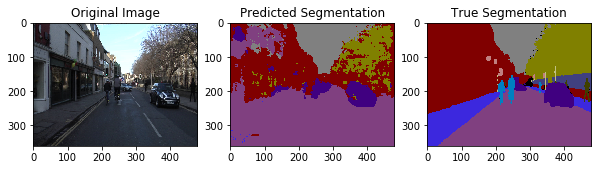

Iter: 1800,Loss: 1.6450464725494385, Acc:0.4960436522960663
Val Acc:0.7192679643630981


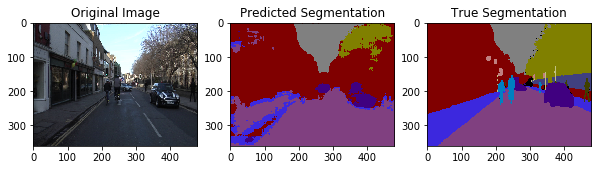

Iter: 1900,Loss: 1.2246639728546143, Acc:0.6603987812995911
Val Acc:0.6437390446662903


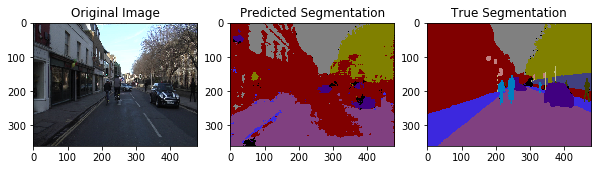

Iter: 2000,Loss: 1.0155977010726929, Acc:0.7555209398269653
Val Acc:0.6972560882568359


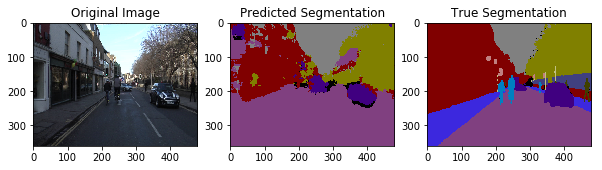

Iter: 2100,Loss: 0.8707200288772583, Acc:0.7802110314369202
Val Acc:0.6495985388755798


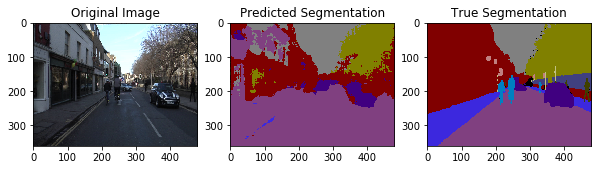

Iter: 2200,Loss: 0.9982893466949463, Acc:0.7491722702980042
Val Acc:0.7510178089141846


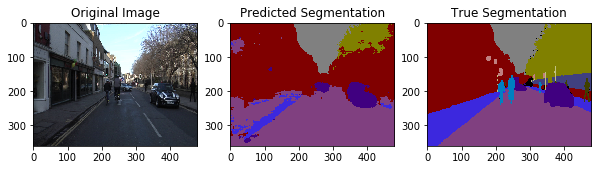

Iter: 2300,Loss: 1.0470982789993286, Acc:0.7209435701370239
Val Acc:0.7268564701080322


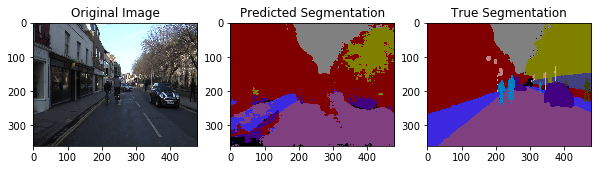

Iter: 2400,Loss: 0.8162278532981873, Acc:0.8028640151023865
Val Acc:0.6569668650627136


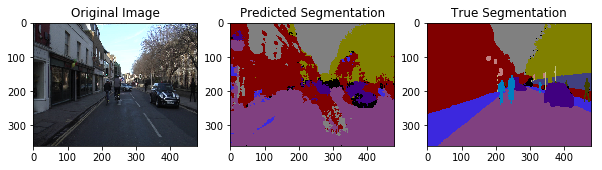

Iter: 2500,Loss: 1.1139496564865112, Acc:0.7146146893501282
Val Acc:0.6502136588096619


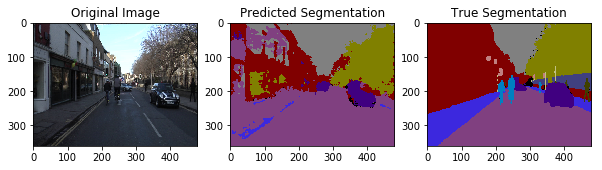

Iter: 2600,Loss: 1.0653082132339478, Acc:0.729261577129364
Val Acc:0.7448090314865112


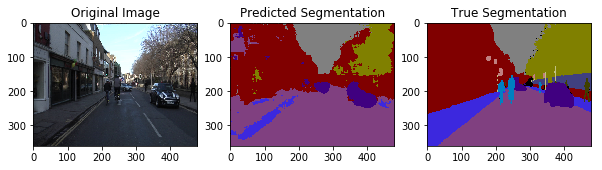

Iter: 2700,Loss: 1.4175716638565063, Acc:0.5764996409416199
Val Acc:0.7979549765586853


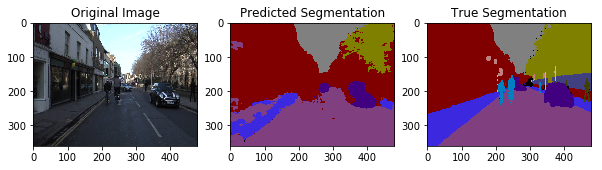

Iter: 2800,Loss: 1.2518588304519653, Acc:0.6543925404548645
Val Acc:0.6824033856391907


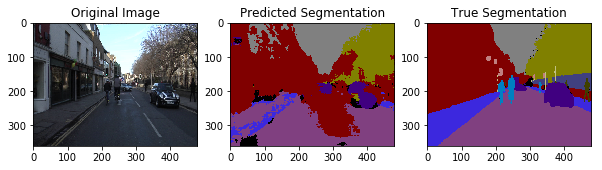

Iter: 2900,Loss: 0.9414241313934326, Acc:0.7792121171951294
Val Acc:0.6867128014564514


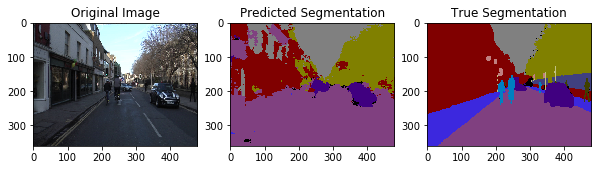

Iter: 3000,Loss: 0.9356727600097656, Acc:0.7687599062919617
Val Acc:0.7120605111122131


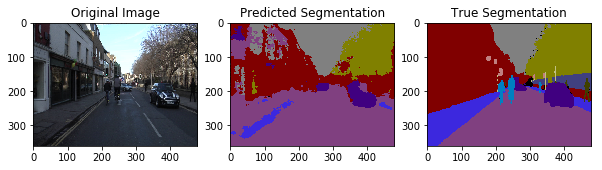

Iter: 3100,Loss: 0.8275784850120544, Acc:0.8171380758285522
Val Acc:0.7789791822433472


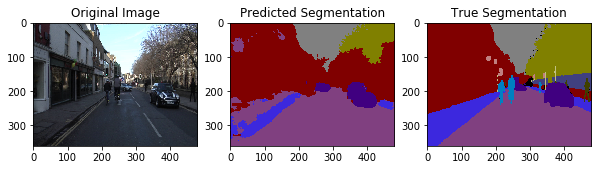

Iter: 3200,Loss: 0.8978105187416077, Acc:0.7433624863624573
Val Acc:0.7583860158920288


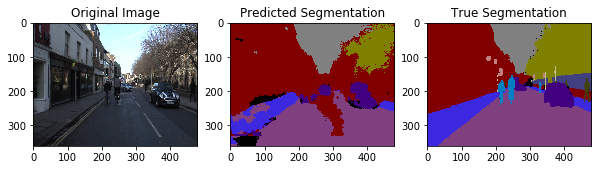

Iter: 3300,Loss: 0.8860803246498108, Acc:0.777391254901886
Val Acc:0.7439926266670227


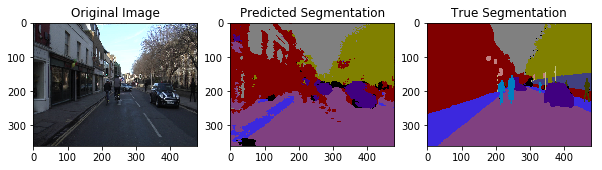

Iter: 3400,Loss: 1.0405220985412598, Acc:0.724224865436554
Val Acc:0.6808639168739319


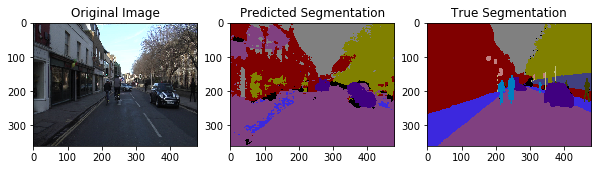

Iter: 3500,Loss: 0.8981080055236816, Acc:0.796954870223999
Val Acc:0.7756478190422058


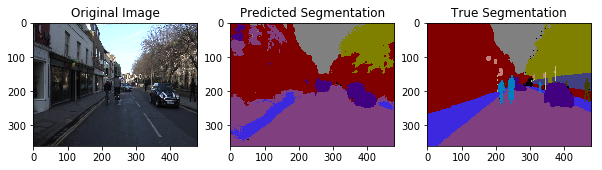

Iter: 3600,Loss: 1.3457647562026978, Acc:0.6003507971763611
Val Acc:0.7984973788261414


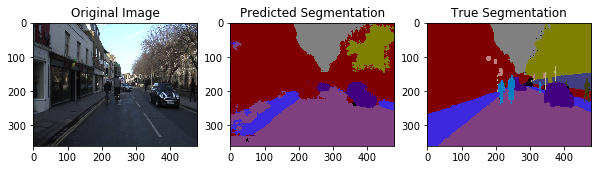

Iter: 3700,Loss: 0.9282424449920654, Acc:0.7798596620559692
Val Acc:0.7445908784866333


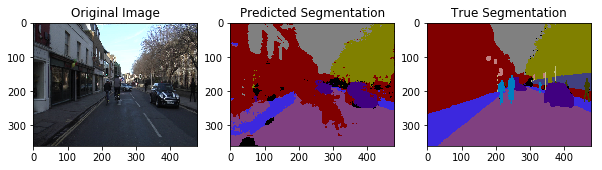

Iter: 3800,Loss: 0.8923822045326233, Acc:0.7954524755477905
Val Acc:0.7354431748390198


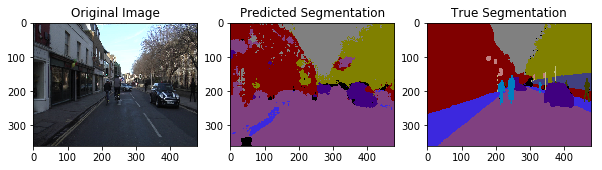

Iter: 3900,Loss: 0.7072471976280212, Acc:0.8654281497001648
Val Acc:0.728032112121582


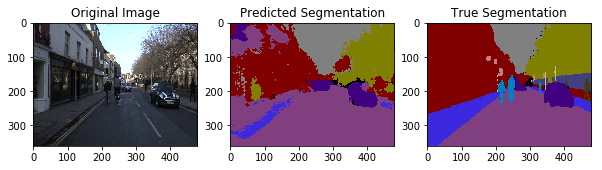

Iter: 4000,Loss: 0.7505060434341431, Acc:0.8476111888885498
Val Acc:0.7964805364608765


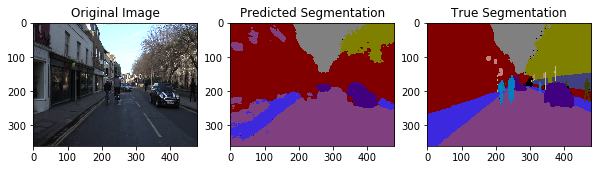

Iter: 4100,Loss: 0.9201541543006897, Acc:0.7527965903282166
Val Acc:0.8002604842185974


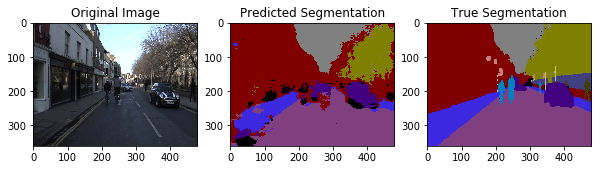

Iter: 4200,Loss: 0.8602750301361084, Acc:0.8057206273078918
Val Acc:0.693630576133728


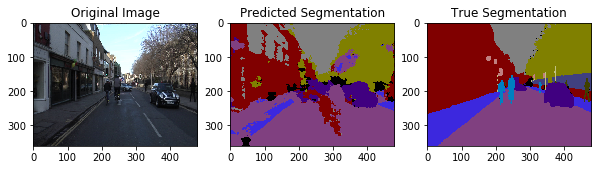

Iter: 4300,Loss: 0.9510067701339722, Acc:0.7919158935546875
Val Acc:0.7018824815750122


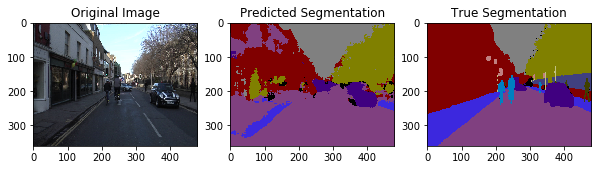

Iter: 4400,Loss: 0.8967691659927368, Acc:0.7923810482025146
Val Acc:0.7897058725357056


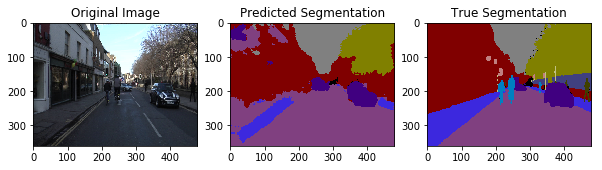

Iter: 4500,Loss: 1.2877403497695923, Acc:0.6253890991210938
Val Acc:0.8145754337310791


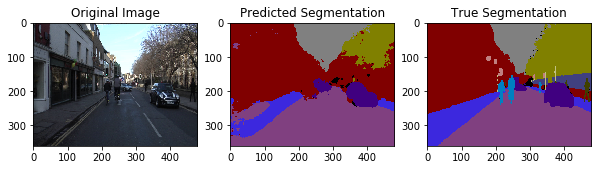

Iter: 4600,Loss: 1.2969809770584106, Acc:0.6674258708953857
Val Acc:0.7414669990539551


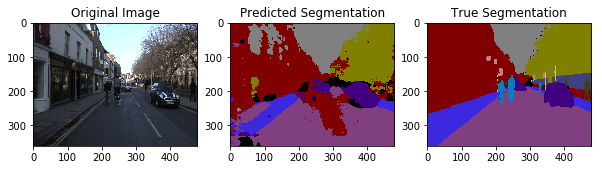

Iter: 4700,Loss: 0.9831125736236572, Acc:0.7761268019676208
Val Acc:0.709959089756012


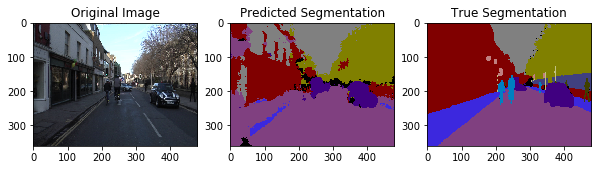

Iter: 4800,Loss: 0.7427181601524353, Acc:0.8457657694816589
Val Acc:0.7129854559898376


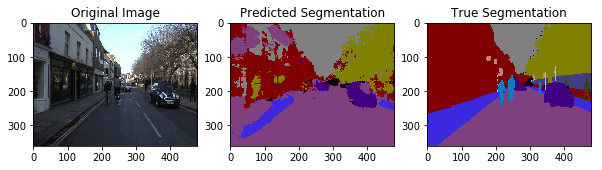

Iter: 4900,Loss: 0.6797555088996887, Acc:0.8643653988838196
Val Acc:0.8208159804344177


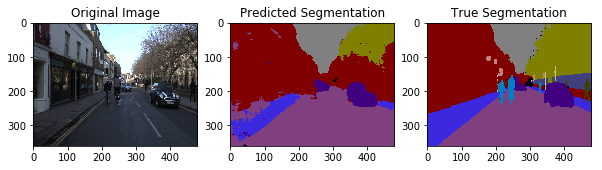

Iter: 5000,Loss: 0.7191233038902283, Acc:0.8434568643569946
Val Acc:0.8291040658950806


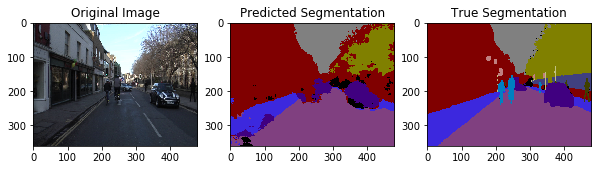

Iter: 5100,Loss: 0.7603920698165894, Acc:0.8248602151870728
Val Acc:0.7655015587806702


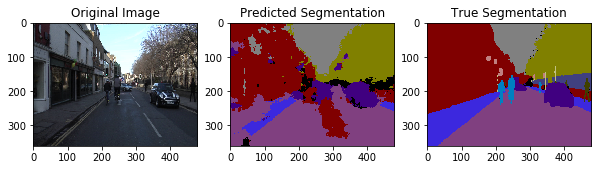

Iter: 5200,Loss: 0.9738013744354248, Acc:0.7703399658203125
Val Acc:0.7349164485931396


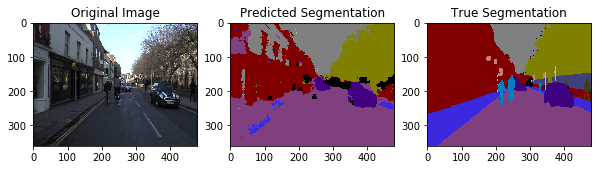

Iter: 5300,Loss: 0.8916743397712708, Acc:0.7865267395973206
Val Acc:0.7913819551467896


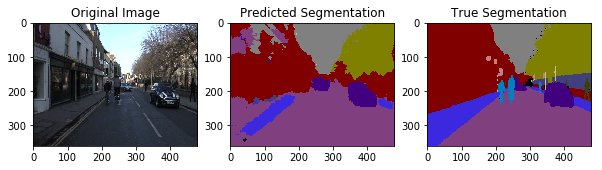

Iter: 5400,Loss: 1.247302532196045, Acc:0.652864396572113
Val Acc:0.834080696105957


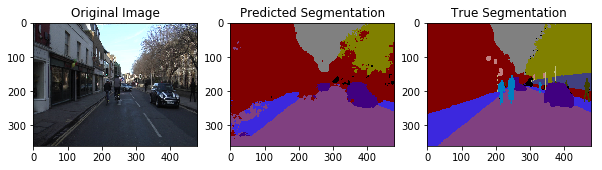

Iter: 5500,Loss: 1.105372667312622, Acc:0.722904622554779
Val Acc:0.8553855419158936


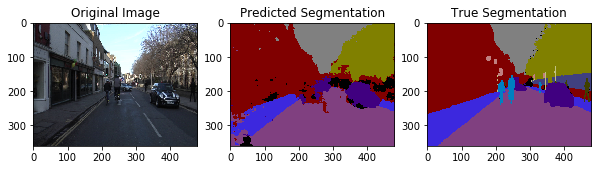

Iter: 5600,Loss: 0.7630996704101562, Acc:0.821199893951416
Val Acc:0.765891969203949


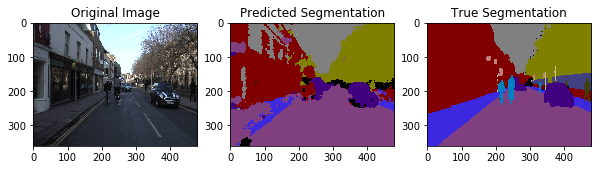

Iter: 5700,Loss: 0.6942566633224487, Acc:0.8675616383552551
Val Acc:0.7909488677978516


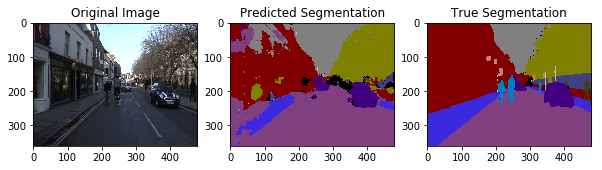

Iter: 5800,Loss: 0.7520841956138611, Acc:0.8239703178405762
Val Acc:0.8249180316925049


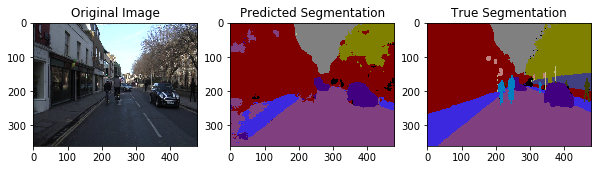

Iter: 5900,Loss: 0.6830125451087952, Acc:0.8643854856491089
Val Acc:0.862787127494812


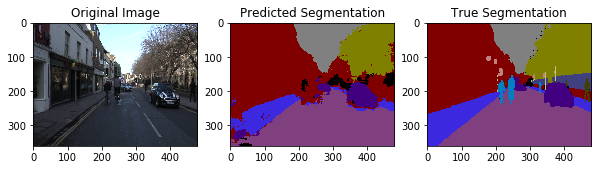

Iter: 6000,Loss: 0.653836190700531, Acc:0.8783977031707764
Val Acc:0.808539867401123


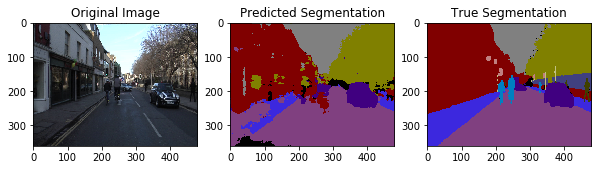

Iter: 6100,Loss: 0.7670851349830627, Acc:0.8326353430747986
Val Acc:0.7421905994415283


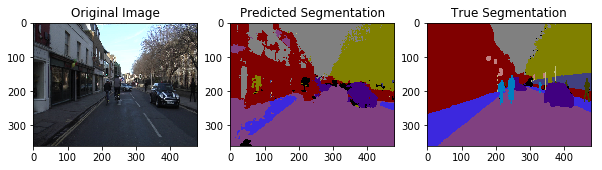

Iter: 6200,Loss: 0.7888392806053162, Acc:0.8416499495506287
Val Acc:0.8503546118736267


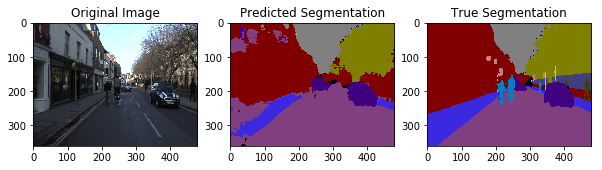

Iter: 6300,Loss: 1.1282917261123657, Acc:0.6934564113616943
Val Acc:0.8425455689430237


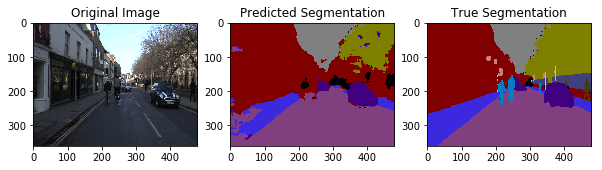

Iter: 6400,Loss: 1.059348464012146, Acc:0.7180877923965454
Val Acc:0.8589451909065247


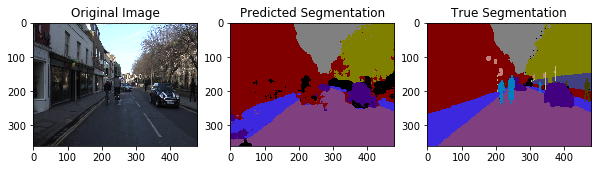

Iter: 6500,Loss: 0.701687753200531, Acc:0.849823534488678
Val Acc:0.8016231656074524


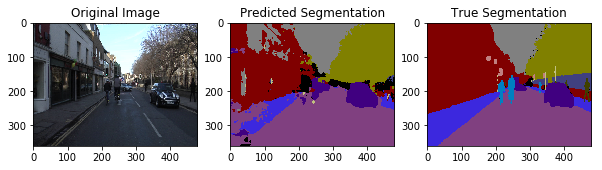

Iter: 6600,Loss: 0.602218747138977, Acc:0.9008116722106934
Val Acc:0.835773229598999


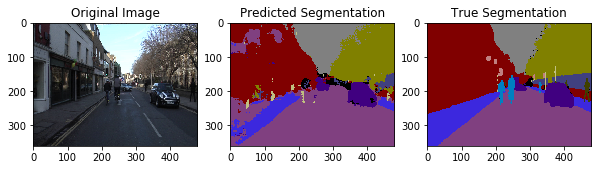

Iter: 6700,Loss: 0.5802668333053589, Acc:0.9025087952613831
Val Acc:0.8393426537513733


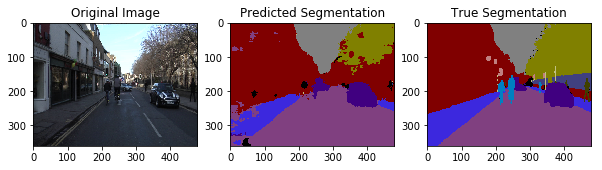

Iter: 6800,Loss: 0.7880383133888245, Acc:0.8436542749404907
Val Acc:0.8897556066513062


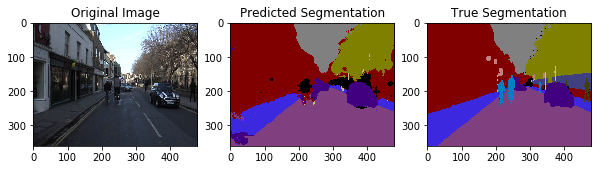

Iter: 6900,Loss: 0.5812957286834717, Acc:0.8951070308685303
Val Acc:0.8537675738334656


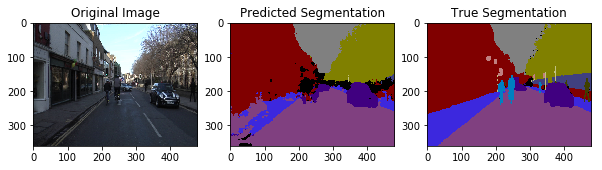

Iter: 7000,Loss: 0.812009871006012, Acc:0.8169448971748352
Val Acc:0.7903649806976318


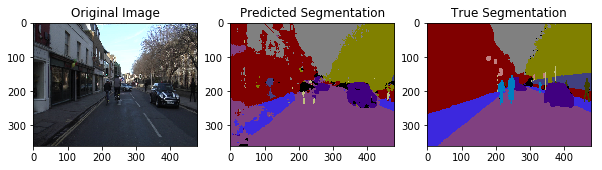

Iter: 7100,Loss: 0.6523916721343994, Acc:0.8986614346504211
Val Acc:0.8677213191986084


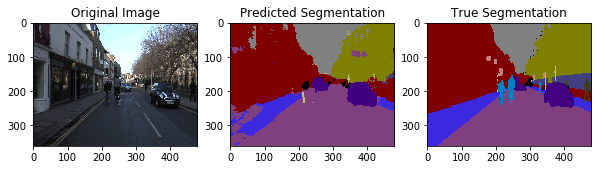

Iter: 7200,Loss: 0.956017017364502, Acc:0.7698969841003418
Val Acc:0.8850101232528687


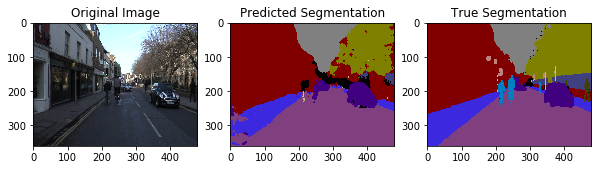

Iter: 7300,Loss: 0.822822630405426, Acc:0.8421948552131653
Val Acc:0.8807039856910706


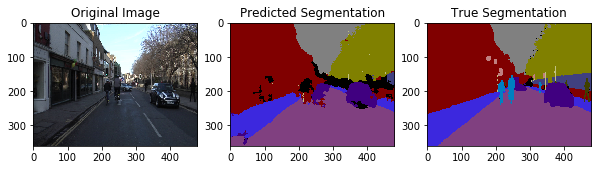

Iter: 7400,Loss: 0.7078258395195007, Acc:0.8393079042434692
Val Acc:0.8215711712837219


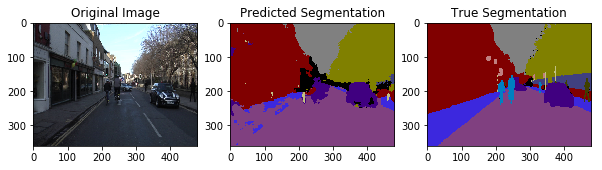

Iter: 7500,Loss: 0.657287061214447, Acc:0.893197238445282
Val Acc:0.8335620760917664


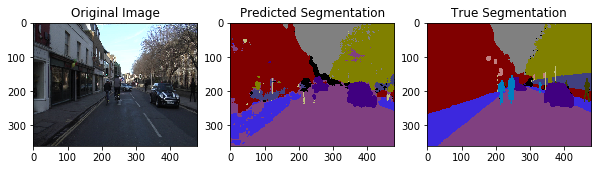

Iter: 7600,Loss: 0.678170919418335, Acc:0.8770278692245483
Val Acc:0.8564842939376831


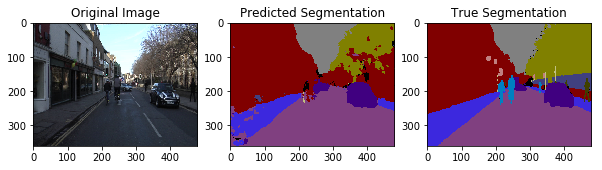

Iter: 7700,Loss: 0.6054803133010864, Acc:0.8918086290359497
Val Acc:0.8723016977310181


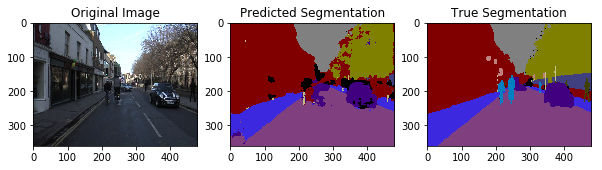

Iter: 7800,Loss: 0.6455671191215515, Acc:0.8836145997047424
Val Acc:0.8463239669799805


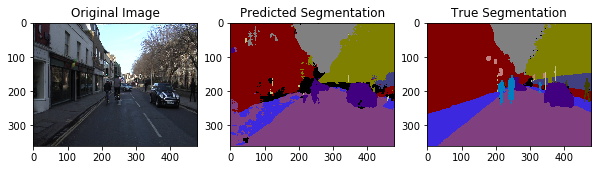

Iter: 7900,Loss: 0.7948670983314514, Acc:0.846268355846405
Val Acc:0.8524145483970642


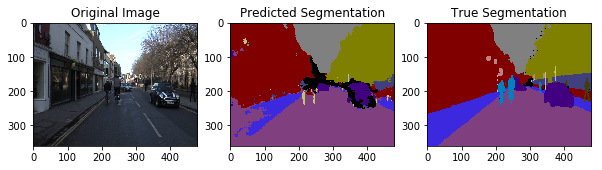

Iter: 8000,Loss: 0.7576760649681091, Acc:0.8529172539710999
Val Acc:0.8712193965911865


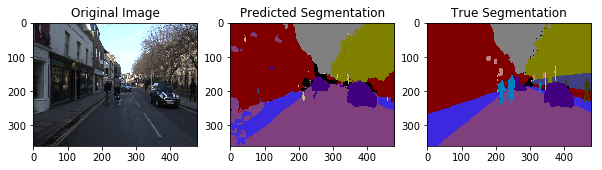

Iter: 8100,Loss: 0.9001791477203369, Acc:0.7957565784454346
Val Acc:0.8752475380897522


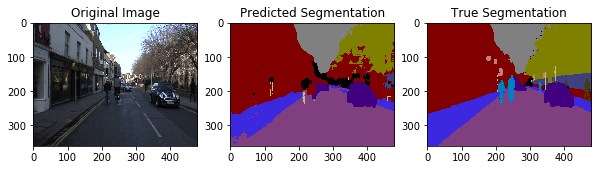

Iter: 8200,Loss: 0.9860489964485168, Acc:0.775702178478241
Val Acc:0.8808482885360718


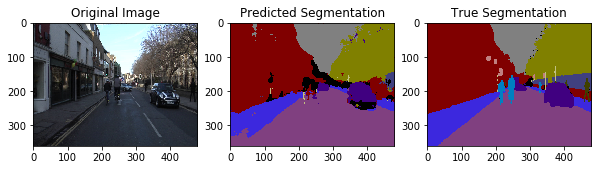

Iter: 8300,Loss: 0.7189072370529175, Acc:0.8533921241760254
Val Acc:0.871842622756958


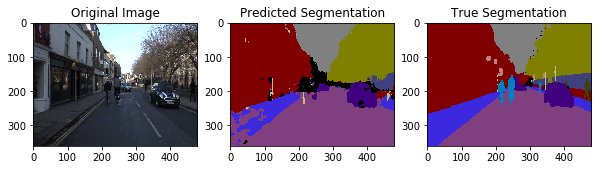

Iter: 8400,Loss: 0.5924155712127686, Acc:0.9118650555610657
Val Acc:0.8620429039001465


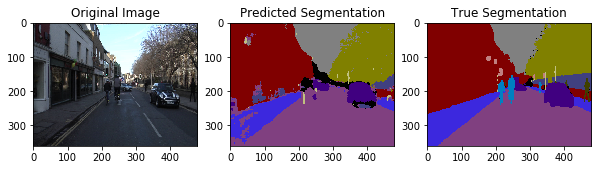

Iter: 8500,Loss: 0.583464503288269, Acc:0.9040891528129578
Val Acc:0.9005886316299438


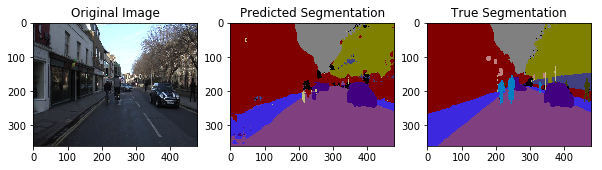

Iter: 8600,Loss: 0.8185963034629822, Acc:0.8268445134162903
Val Acc:0.8752025961875916


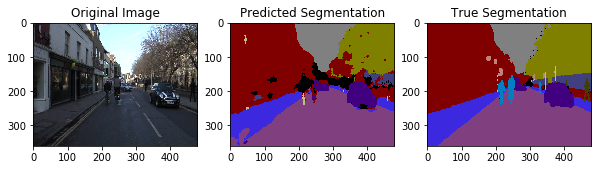

Iter: 8700,Loss: 0.5917779803276062, Acc:0.8955433964729309
Val Acc:0.8763902187347412


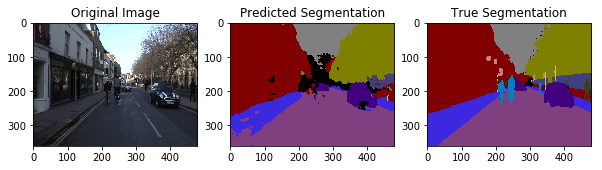

Iter: 8800,Loss: 0.6377296447753906, Acc:0.8762441873550415
Val Acc:0.8624494075775146


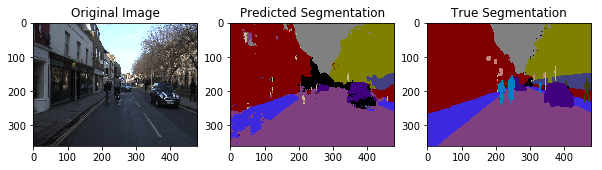

Iter: 8900,Loss: 0.6105872988700867, Acc:0.9194149374961853
Val Acc:0.8760424852371216


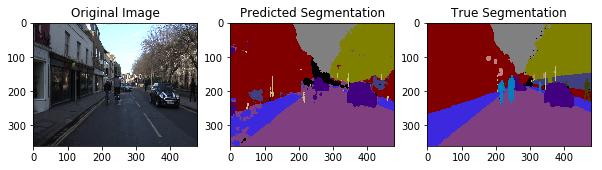

Iter: 9000,Loss: 0.9300632476806641, Acc:0.7955564260482788
Val Acc:0.9038435816764832


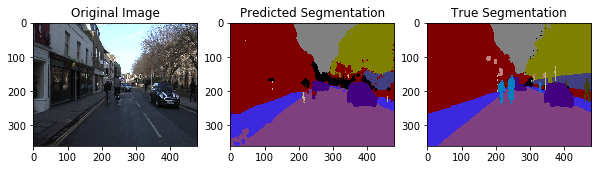

Iter: 9100,Loss: 0.9791402816772461, Acc:0.7931327223777771
Val Acc:0.8842035531997681


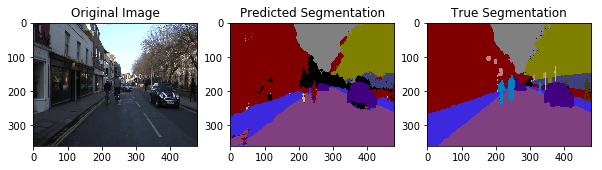

Iter: 9200,Loss: 0.5923187732696533, Acc:0.8853969573974609
Val Acc:0.8411881923675537


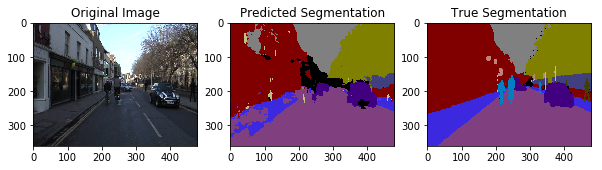

Iter: 9300,Loss: 0.6057689189910889, Acc:0.9157202839851379
Val Acc:0.8763348460197449


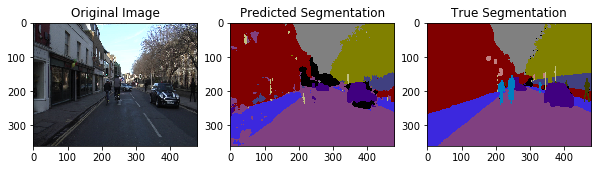

Iter: 9400,Loss: 0.5536450743675232, Acc:0.906399667263031
Val Acc:0.8868210911750793


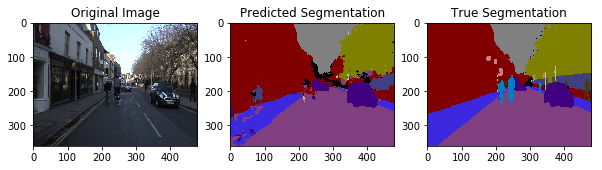

Iter: 9500,Loss: 0.6664887070655823, Acc:0.8796671032905579
Val Acc:0.8963174223899841


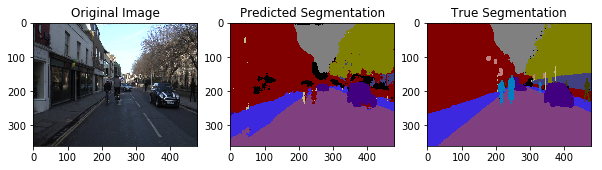

Iter: 9600,Loss: 0.5461395382881165, Acc:0.9071938395500183
Val Acc:0.8707380890846252


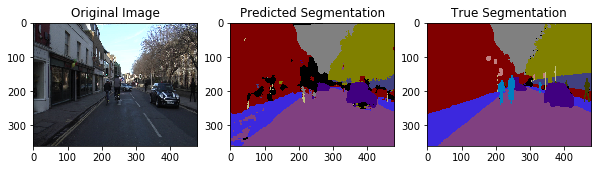

Iter: 9700,Loss: 0.7252275347709656, Acc:0.8559750318527222
Val Acc:0.8203300833702087


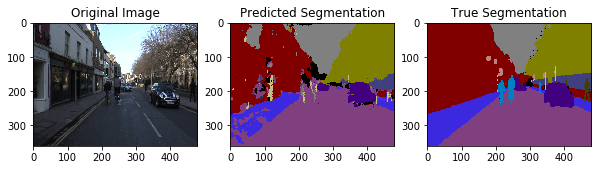

Iter: 9800,Loss: 0.6093353629112244, Acc:0.9229603409767151
Val Acc:0.8880311846733093


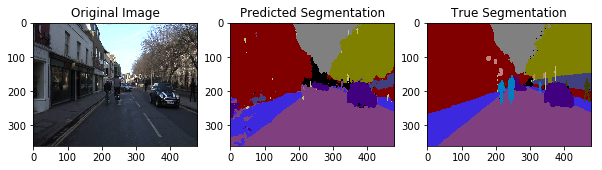

Iter: 9900,Loss: 0.9884296655654907, Acc:0.7866156697273254
Val Acc:0.9153999090194702


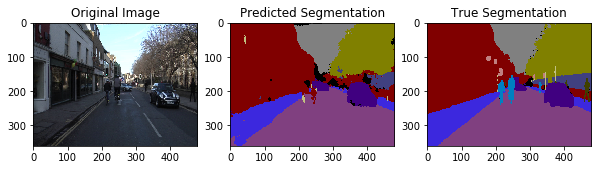

Iter: 10000,Loss: 1.0469648838043213, Acc:0.7756774425506592
Val Acc:0.8879454731941223


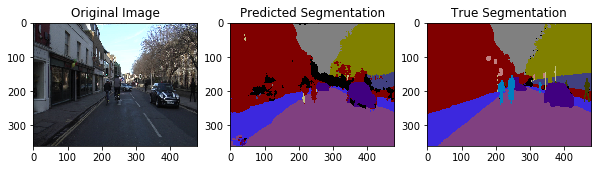

Iter: 10100,Loss: 0.5718565583229065, Acc:0.8944608569145203
Val Acc:0.8693878650665283


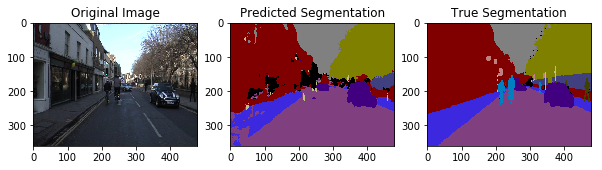

Iter: 10200,Loss: 0.5181207656860352, Acc:0.9425339102745056
Val Acc:0.8933758735656738


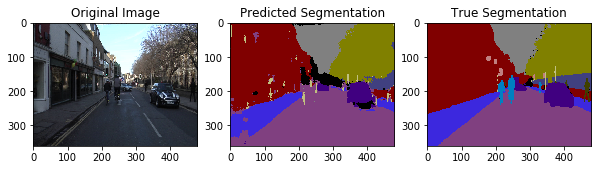

Iter: 10300,Loss: 0.5665470361709595, Acc:0.9065827131271362
Val Acc:0.9079972505569458


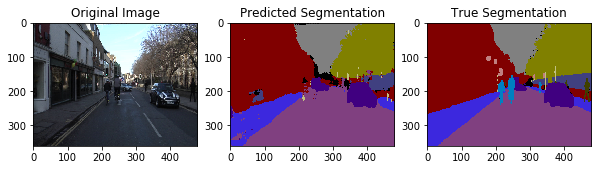

Iter: 10400,Loss: 0.5676143169403076, Acc:0.9142776131629944
Val Acc:0.9106143116950989


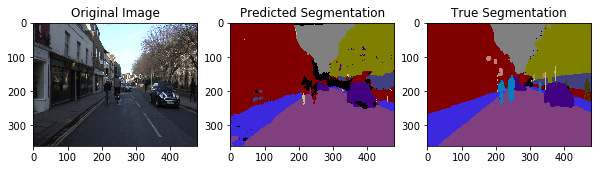

Iter: 10500,Loss: 0.5443816781044006, Acc:0.9154988527297974
Val Acc:0.8949569463729858


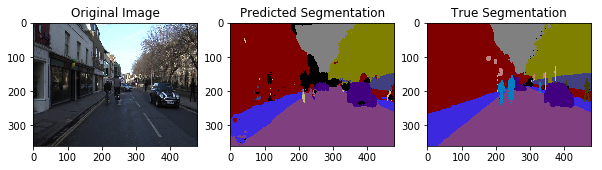

Iter: 10600,Loss: 0.6326174736022949, Acc:0.8847736120223999
Val Acc:0.8637524247169495


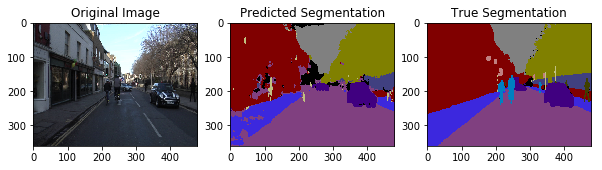

Iter: 10700,Loss: 0.5552390217781067, Acc:0.9349615573883057
Val Acc:0.9084247350692749


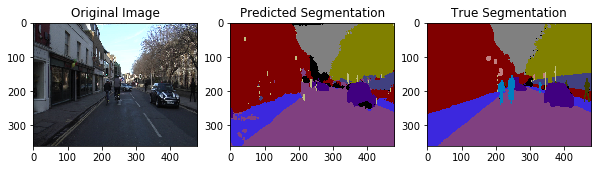

Iter: 10800,Loss: 0.8340198397636414, Acc:0.8377121090888977
Val Acc:0.9138530492782593


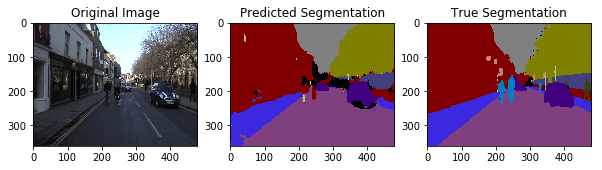

Iter: 10900,Loss: 0.813500165939331, Acc:0.8466956615447998
Val Acc:0.898297131061554


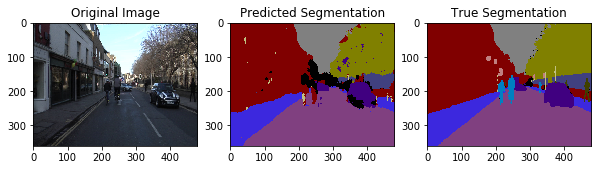

Iter: 11000,Loss: 0.5347666144371033, Acc:0.9124240279197693
Val Acc:0.8873584270477295


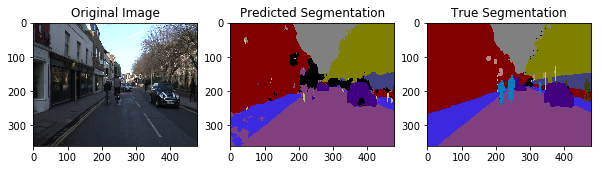

Iter: 11100,Loss: 0.5499977469444275, Acc:0.9219636917114258
Val Acc:0.8893532752990723


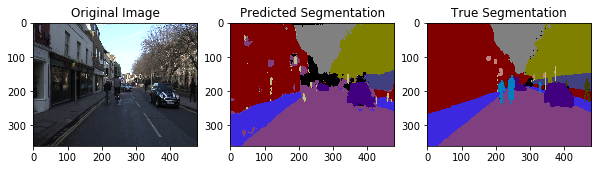

Iter: 11200,Loss: 0.5282779335975647, Acc:0.91916823387146
Val Acc:0.9027704000473022


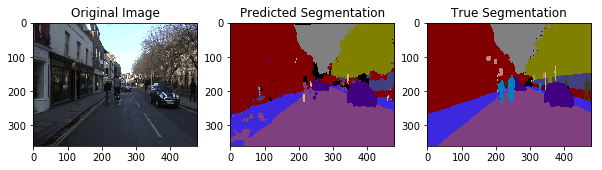

In [ ]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
sess.run(train_iterator.initializer)

for i in range(NUM_ITERS):
    train_image, train_labels =sess.run(train_iterator.get_next())
    if len(train_image) < TRAIN_BATCH_SIZE:
        sess.run(train_iterator.initializer)
        train_image, train_labels =sess.run(train_iterator.get_next())
    _, loss_,accuracy_ = sess.run([optimizer,loss, accuracy], feed_dict={inputs: train_image, labels:train_labels,
                                                  is_training: True})
    
    if i % 100 == 0:
        print(f"Iter: {i},Loss: {loss_}, Acc:{accuracy_}")
        if i > 0:
            sess.run(val_iterator.initializer)
            val_image, val_labels = sess.run(val_iterator.get_next())
            val_acc,preds = sess.run([accuracy,predicted_annotations],
                                     feed_dict={inputs: val_image, labels:val_labels,
                                                         is_training: False})
            print(f"Val Acc:{val_acc}")
            visualize_image_annot(val_image[0],val_labels[0],preds[0])